In [1]:
import argparse
import os
import sys
import datetime
import time
import math
import json
from pathlib import Path

sys.path.insert(0, '..')
sys.path.insert(0, '../dino')

import prepare_analysis as pt

import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.distributed as dist
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision import models as torchvision_models

import utils
import vision_transformer as vits
import protosim as pvits
from vision_transformer import DINOHead

import matplotlib.pyplot as plt

In [2]:
data_path = '/home/nanne/workspace/data/ImageNet1K/train,/home/nanne/workspace/data/PASS_dataset'
checkpoint_dir = 'checkpoints_passnet'

argstr = f"--arch pvit_small --batch_size_per_gpu=128 --use_fp16=False --output_dir={checkpoint_dir} --num_prototypes=8192 --patch_size=16 --data_path={data_path}"

args = pt.get_args_parser().parse_args(argstr.split(' '))

Using cache found in /home/nanne/.cache/torch/hub/facebookresearch_xcit_main


In [3]:
args

Namespace(arch='pvit_small', patch_size=16, out_dim=65536, norm_last_layer=True, momentum_teacher=0.996, use_bn_in_head=False, warmup_teacher_temp=0.04, teacher_temp=0.04, warmup_teacher_temp_epochs=0, use_fp16=False, weight_decay=0.04, weight_decay_end=0.4, clip_grad=3.0, batch_size_per_gpu=128, epochs=100, freeze_last_layer=1, lr=0.0005, warmup_epochs=10, min_lr=1e-06, optimizer='adamw', drop_path_rate=0.1, global_crops_scale=(0.4, 1.0), local_crops_number=8, local_crops_scale=(0.05, 0.4), data_path='/home/nanne/workspace/data/ImageNet1K/train,/home/nanne/workspace/data/PASS_dataset', output_dir='checkpoints_passnet', saveckp_freq=20, seed=0, num_workers=10, dist_url='env://', local_rank=0, num_prototypes=8192)

In [4]:
test_transform = transforms.Compose([
    transforms.Resize(256, interpolation=3),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

dataset_gallery, _ = pt.build_dataset(data_path=args.data_path, transform=test_transform, indexed=True)
data_loader_gallery = torch.utils.data.DataLoader(
    dataset_gallery,
    batch_size=args.batch_size_per_gpu,
    num_workers=args.num_workers,
    pin_memory=True,
    drop_last=False,
)

# ============ building student and teacher networks ... ============
if args.arch in pvits.__dict__.keys():
    model = pvits.__dict__[args.arch](
        num_prototypes=args.num_prototypes, 
        patch_size=args.patch_size,
        num_classes=0
    )
    model.protoAT.hard = True
    model.protoAT.gumbel = False
    embed_dim = model.embed_dim
else:
    print(f"Unknow architecture: {args.arch}")

student = utils.MultiCropWrapper(model, nn.Identity())

# move networks to gpu
student = student.cuda()
# synchronize batch norms (if any)
if utils.has_batchnorms(student):
    student = nn.SyncBatchNorm.convert_sync_batchnorm(student)

student = nn.parallel.DataParallel(student)
print(f"Student built: it's a {args.arch} network.")

# ============ optionally resume training ... ============
to_restore = {"epoch": 0}
utils.restart_from_checkpoint(
    os.path.join(args.output_dir, "checkpoint.pth"),
    run_variables=to_restore,
    student=student,
)
start_epoch = to_restore["epoch"]

# get rid off MCW
student = student.module.backbone


/home/nanne/miniconda3/lib/python3.9/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


Student built: it's a pvit_small network.


In [5]:
print(dataset_gallery.cumulative_sizes)
poffsets = [0] + dataset_gallery.cumulative_sizes

[1281167, 2720886]


In [6]:
# Find the index of an image with a specific filename
fn = "00729a3eb66f937e484cf8f9547146.jpg"

for i, d in enumerate(dataset_gallery.datasets):
    found = [ x for x in enumerate(d.samples) if x[1][0].endswith(fn)]
    if len(found) > 0:
        print(found[0][0]+poffsets[i], found[0][1])

1281167 ('/home/nanne/workspace/data/PASS_dataset/0/00729a3eb66f937e484cf8f9547146.jpg', 0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

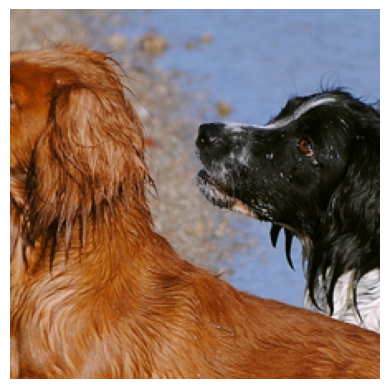

In [7]:
# image index and dataset index for the image to process

f = 1281167
dset = 1

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)
plt.imshow(inv_normalize(dataset_gallery[f][0]).permute(1,2,0))
plt.axis('off')

In [8]:
# forward image and get hard attention mask
attn = student(dataset_gallery[f][0].unsqueeze(0).cuda(), return_attn=True)

y_soft = attn.softmax(dim=1)
index = y_soft.max(1, keepdim=True)[1]
hard_attn = torch.zeros_like(attn, memory_format=torch.legacy_contiguous_format).scatter_(1, index, 1.0).detach().cpu().numpy()
attn = attn.detach().cpu().numpy()
attn.shape

(1, 8192, 197)

In [9]:
hard_attn.shape

(1, 8192, 197)

In [10]:
# top cls token prototypes for this image
for x in np.argsort(hard_attn[0,:,0].flatten())[::-1][:5]:
    print(x, hard_attn[0,x,0])

3402 1.0
8191 0.0
2734 0.0
2721 0.0
2722 0.0


In [11]:
# top non-class token prototypes for this image
top_spatial = []
for x in np.argsort(hard_attn[0,:,1:].sum(axis=1).flatten())[::-1][:5]:
    print(x, hard_attn[0,x,1:].sum())
    top_spatial.append(x)

5267 32.0
6595 17.0
2803 14.0
2575 9.0
7493 9.0


(-0.5, 13.5, 13.5, -0.5)

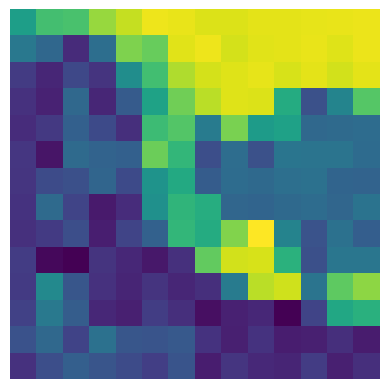

In [12]:
# visualise where prototype ff activates
ff = top_spatial[0]

plt.imshow(attn[0,ff,1:].reshape(14,14))
plt.axis('off')

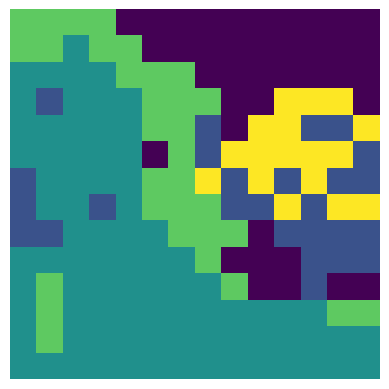

In [13]:
# visualisation of top spatial prototypes
plt.imshow(attn[0,top_spatial[0:],1:].argmax(0).reshape(14,14))
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


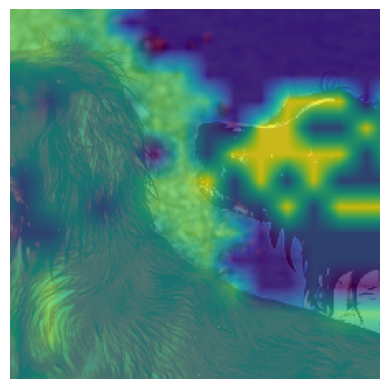

In [14]:
# overlay top spatial onto image

from skimage.transform import resize

plt.imshow(dataset_gallery[f][0].permute(1,2,0))
plt.imshow(resize(attn[0,top_spatial[0:],1:].argmax(0).reshape(14,14), (224,224)), alpha=0.8)
plt.axis('off')
plt.show()